In [29]:
# Plot 3C waveforms of the whole array in a time window

In [30]:
## Import modules
from obspy import read, UTCDateTime, Stream
from matplotlib.pyplot import figure, subplots
import matplotlib.dates as mdates
from numpy import abs, mean, amin, amax
from pandas import read_csv
from os.path import join
from utils_preproc import preprocess_stream
from datetime import datetime

In [31]:
## Inputs
root = "/Volumes/OmanData/geophones_no_prefilt/data"
subarray = "A"
starttime = "2020-01-11T19:40:00"
dur = 180.0 # Duration in seconds

freqmin = 10.0
freqmax = 450

scale = 1e-5 # Scale factor for plotting

In [32]:
## Read the station list
inpath = join(root, "stations.csv")
stadf = read_csv(inpath, delimiter=" ", index_col=0)
numst = len(stadf)

In [33]:
## Read and preprocess the data
starttime = UTCDateTime(starttime)
timewin = starttime.strftime("%Y-%m-%d-%H-00-00")
stream = Stream()
for station in stadf["name"]:
    try:
        pattern = join(root, timewin, f"*{station}*.SAC")
        stream += read(pattern)
    except:
        print(f"Could not read Station {station}")
        continue

stream = preprocess_stream(stream, freqmin, freqmax)
stream.trim(starttime, starttime + dur)

Could not read Station B05


114 Trace(s) in Stream:

7F.A01..GH1 | 2020-01-11T19:40:00.000146Z - 2020-01-11T19:43:00.000157Z | 1000.0 Hz, 180001 samples
...
(112 other traces)
...
7F.B20..GHZ | 2020-01-11T19:40:00.000146Z - 2020-01-11T19:43:00.000157Z | 1000.0 Hz, 180001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

Could not plot B05


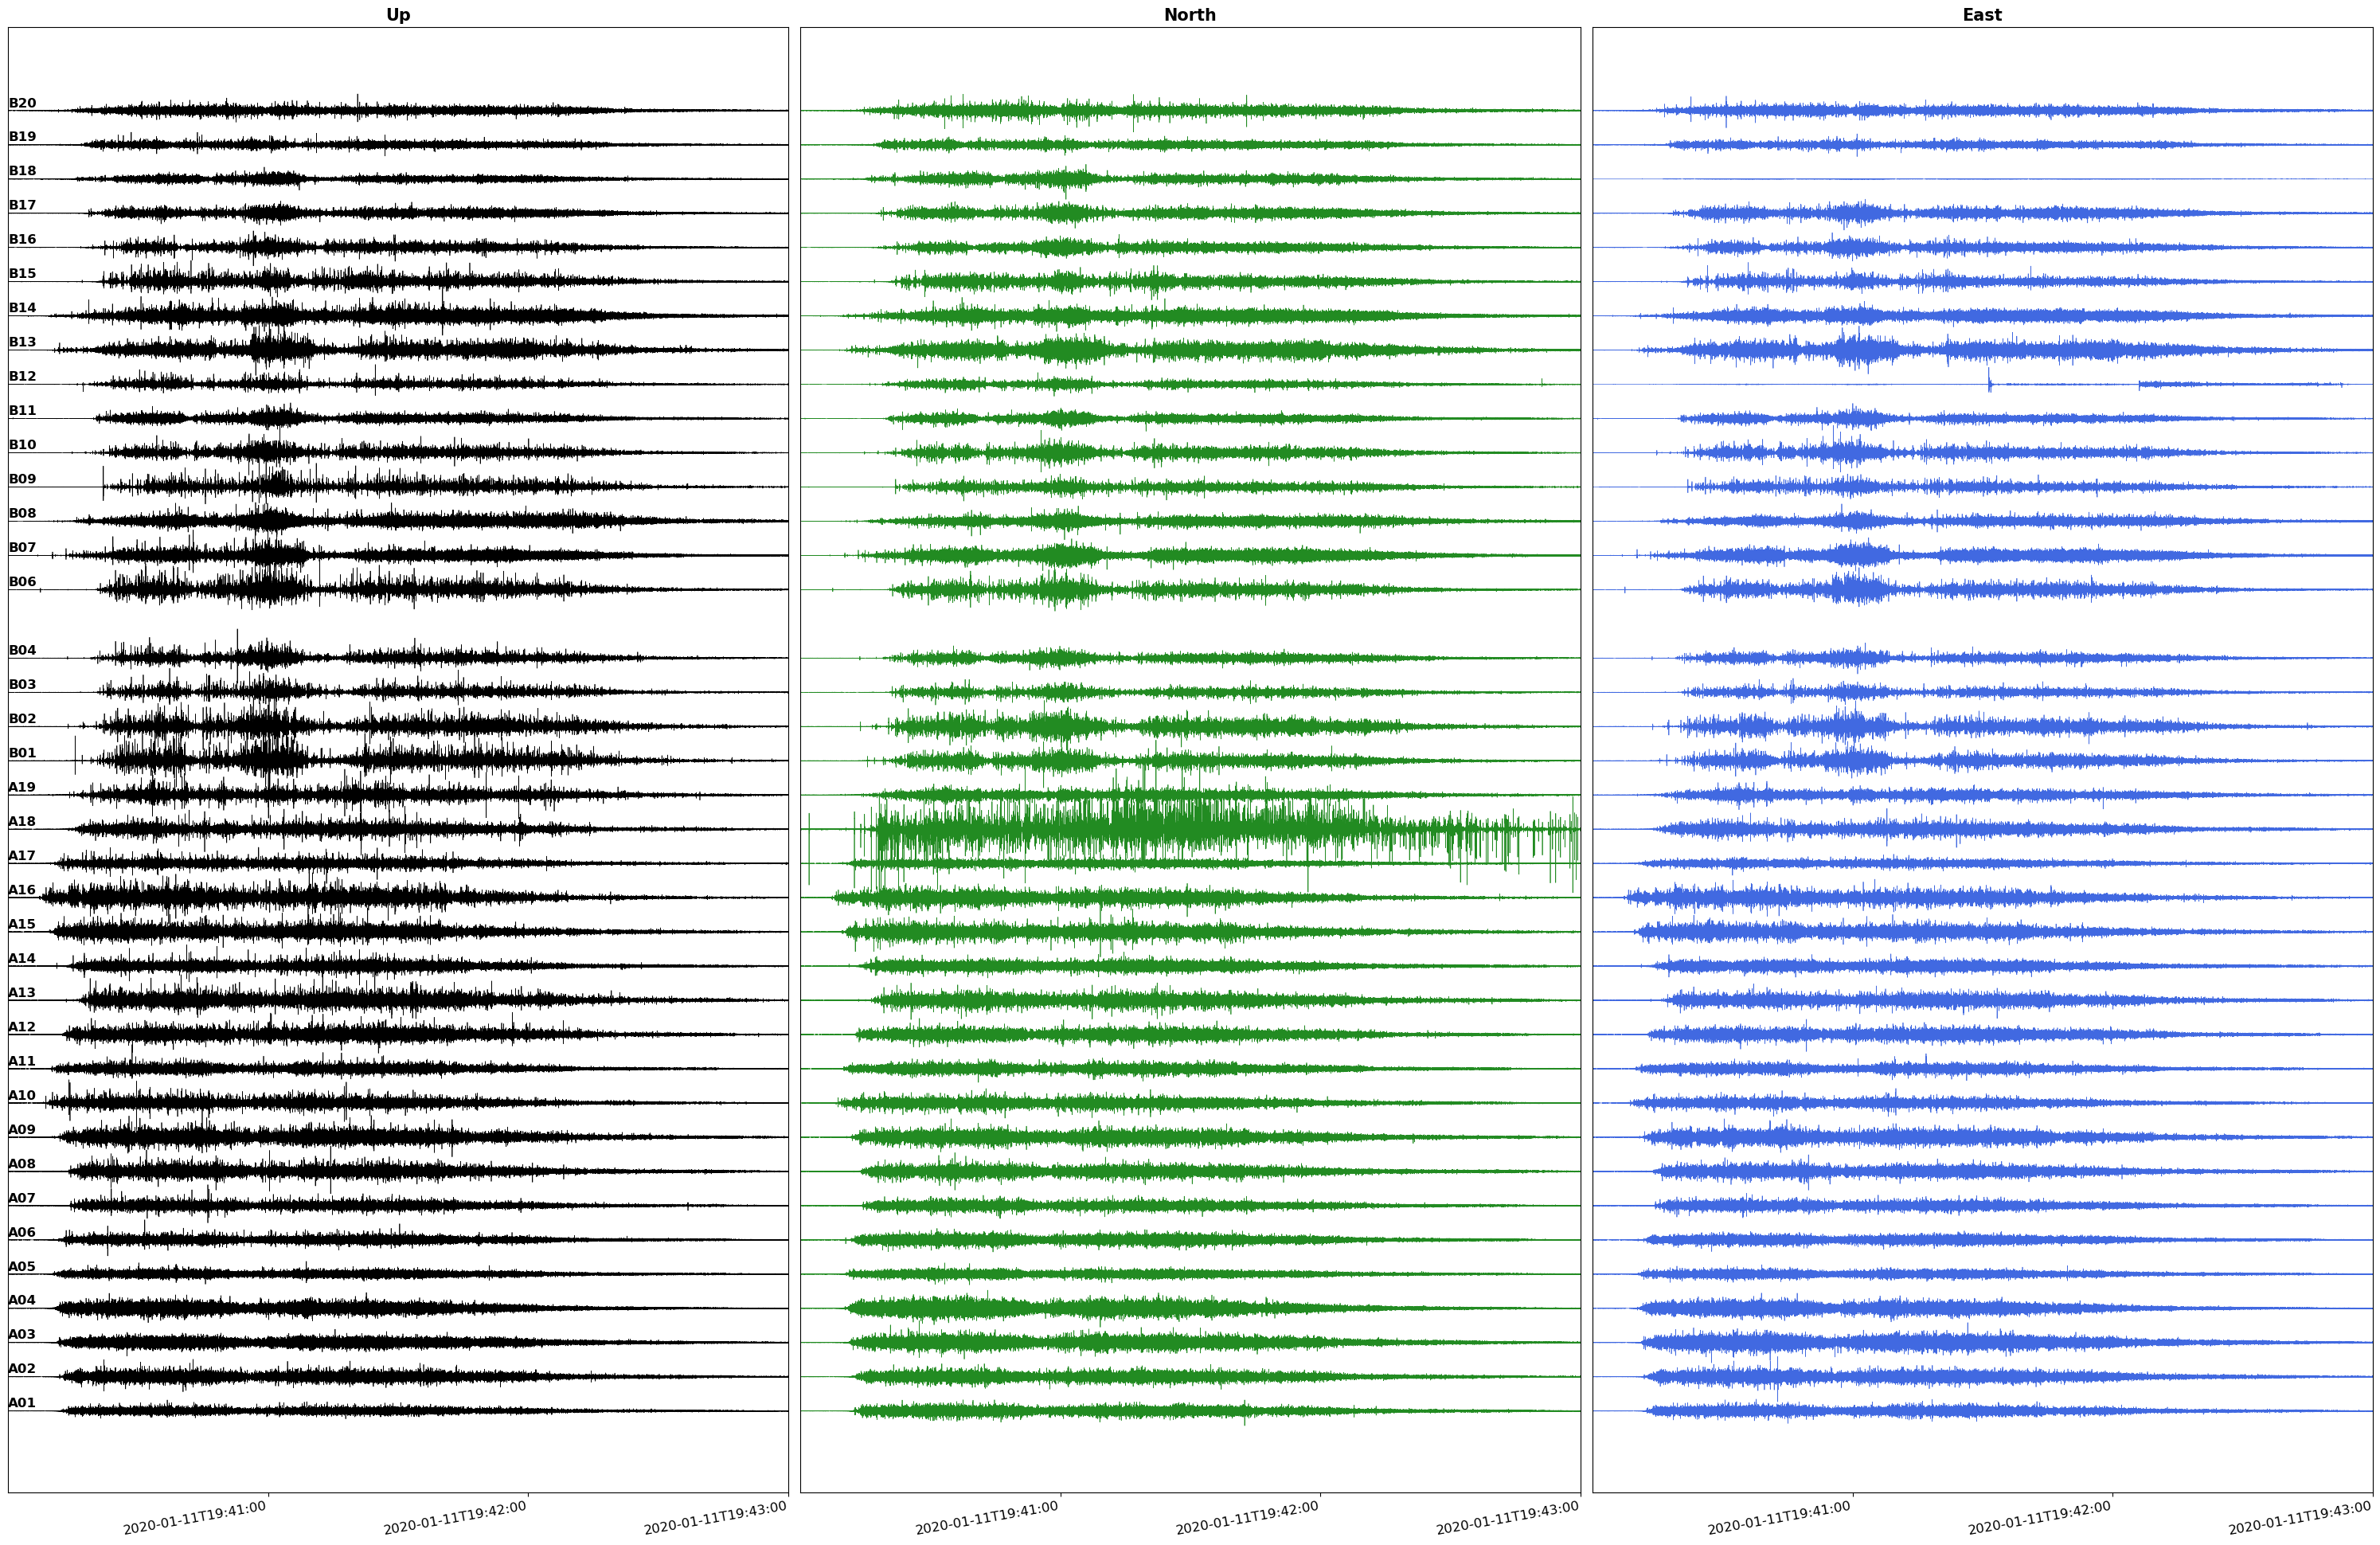

In [34]:
fig, axes = subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(25, 0.5*numst))

for i, station in enumerate(stadf["name"]):
    try:
        trace_z = stream.select(station=station, channel="*Z")[0]
        trace_1 = stream.select(station=station, channel="*1")[0]
        trace_2 = stream.select(station=station, channel="*2")[0]

        data_z = trace_z.data * scale + i
        data_1 = trace_1.data * scale + i
        data_2 = trace_2.data * scale + i
    except:
        print(f"Could not plot {station}")
        continue

    timeax = trace_z.times("matplotlib")

    axes[0].plot(timeax, data_z, color="black", linewidth=0.5)
    axes[1].plot(timeax, data_1, color="forestgreen", linewidth=0.5)
    axes[2].plot(timeax, data_2, color="royalblue", linewidth=0.5)

    axes[0].annotate(station, xy=(timeax[0], i+0.1), xycoords="data", fontsize=15, fontweight="bold")

    axes[0].set_xlim([timeax[0], timeax[-1]])
    axes[1].set_xlim([timeax[0], timeax[-1]])
    axes[2].set_xlim([timeax[0], timeax[-1]])

# Format x-axis as date time
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%dT%H:%M:%S'))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%dT%H:%M:%S'))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%dT%H:%M:%S'))

for label in axes[0].get_xticklabels():
    label.set_fontsize(15)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

for label in axes[1].get_xticklabels():
    label.set_fontsize(15)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

for label in axes[2].get_xticklabels():
    label.set_fontsize(15)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

# Set titles
axes[0].set_title("Up", fontsize=20, fontweight="bold")
axes[1].set_title("North", fontsize=20, fontweight="bold")
axes[2].set_title("East", fontsize=20, fontweight="bold")

# Set x label spacing to 60 seconds
axes[0].xaxis.set_major_locator(mdates.SecondLocator(interval=60))
axes[1].xaxis.set_major_locator(mdates.SecondLocator(interval=60))
axes[2].xaxis.set_major_locator(mdates.SecondLocator(interval=60))

# Turn off the y-axis labels and ticks
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[2].set_yticks([])

axes[0].set_yticklabels([])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

fig.tight_layout()


In [35]:
## Save the figure
filename = f"sample_waveforms.png"

outpath = join(root, timewin, filename)
fig.savefig(outpath, dpi=300, transparent=True)